In [529]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [530]:
datapath = "data/"

In [531]:
def get_normalization_params(dataset_name, datapath):
    if dataset_name == "cifar10":
        # stds are different in paper wtf
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        pass
    elif dataset_name == "clothing1m":
        pass
    else:
        raise Exception
    
    means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
    stds = train_dataset.data.std(axis=(0,1,2)) / 255.0
    
    return means, stds

In [532]:
def get_transforms(dataset_name, **kwargs):
    means, stds = kwargs["means"], kwargs["stds"]
    
    if dataset_name == "cifar10":
        train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4), 
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(means, stds)])

        test_transform = transforms.Compose([transforms.ToTensor(), 
                                             transforms.Normalize(means, stds)])
    elif dataset_name == "cifar100":
        pass
    
    elif dataset_name == "clothing1m":
        pass
    
    else:
        raise Exception
    
    return train_transform, test_transform

In [533]:
def get_splits(dataset_name, datapath, **kwargs):
    train_transform, test_transform = kwargs["train_transform"], kwargs["test_transform"]
    
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
        test_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=False, transform=test_transform)
    
    elif dataset_name == "cifar100":
        pass
    
    elif dataset_name == "clothing1m":
        pass
    
    else:
        raise Exception
    
    return train_dataset, test_dataset

In [534]:
def get_datasets(dataset_name, datapath):
    means, stds = get_normalization_params(dataset_name, datapath)
    
    transform_params = {"means": means, "stds": stds}
    train_transform, test_transform = get_transforms(dataset_name, **transform_params)
    
    transforms = {"train_transform": train_transform, "test_transform": test_transform}
    train_dataset, test_dataset = get_splits(dataset_name, datapath, **transforms)
    
    return train_dataset, test_dataset

In [535]:
# https://pytorch.org/docs/stable/notes/randomness.html

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

def get_datta_loaders():
    pass

In [536]:
dataset_name = "cifar10"
train_dataset, test_dataset = get_datasets(dataset_name, datapath)

Files already downloaded and verified
Files already downloaded and verified


In [537]:
print(train_dataset)
print(test_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [538]:
type(train_dataset.data)

numpy.ndarray

In [539]:
np.save("test.npy", train_dataset.data)

In [540]:
train_data_2 = np.load("test.npy")

In [541]:
np.all(train_dataset.data == train_data_2)

True

In [542]:
def assert_dataset_name_and_noise_mode_combos(dataset_name, noise_mode):
    cifar10_sym_condition = dataset_name == "cifar10" and noise_mode == "sym"
    cifar10_asym_condition = dataset_name == "cifar10" and noise_mode == "asym"
    cifar100_sym_condition = dataset_name == "cifar100" and noise_mode == "sym"
    cifar100_asym_condition = dataset_name == "cifar100" and noise_mode == "asym"
    cifar10_dependent_condition = dataset_name == "cifar10" and noise_mode == "dependent"
    cifar100_dependent_condition = dataset_name == "cifar100" and noise_mode == "dependent"
    cifar10_openset_condition = dataset_name == "cifar10" and noise_mode == "openset"
    
    assert (
        cifar10_sym_condition or cifar10_asym_condition or \
        cifar100_sym_condition or cifar100_asym_condition or \
        cifar10_dependent_condition or cifar100_dependent_condition or \
        cifar10_openset_condition
    )
    

def make_inherent_label_noise(datapath, dataset_name, noise_mode, p, seed=None):
    # check combos
    assert_dataset_name_and_noise_mode_combos(dataset_name=dataset_name, noise_mode=noise_mode)
    
    if noise_mode in ["sym", "asym"]:
        kwargs = make_inherent_label_noise_sym_asym(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "openset":
        kwargs = make_inherent_label_noise_openset(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "dependent":
        kwargs = make_inherent_label_noise_dependent(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=None)
    else:
        raise Exception
        
    return kwargs
    
def make_inherent_label_noise_openset(datapath, dataset_name, noise_mode, p, seed=None):
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    
    #p = 0.4
    noise_rules = make_openset_noise_rules(dataset_name=dataset_name, p=p)
    train_openset_dataset_data = np.copy(train_dataset.data)
    indices_set = set()
    
    # only one noise rule for now
    for noise_rule in noise_rules:
        indices_per_rule, openset_data_per_rule = \
            make_openset_noise(train_dataset=train_dataset, src=noise_rule["src"], dst=noise_rule["dst"], p=noise_rule["p"], seed=seed)
        indices_set.update(list(indices_per_rule))
        train_openset_dataset_data[indices_per_rule] = openset_data_per_rule
    
    indices = list(indices_set)
    labels_noisy = np.array([False for i in range(len(train_dataset))])    
    labels_noisy[indices] = True

    labels_df = pd.DataFrame(data={"label": train_dataset.targets, "label_noisy": labels_noisy})
    labels_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.csv" 
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    dataset_data_npy_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.npy"
    np.save(dataset_data_npy_path, train_openset_dataset_data)
    print(f"{dataset_data_npy_path} generated\n")
    
    kwargs = {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path,
        "dataset_data_npy_path": dataset_data_npy_path,
    }
    
    return kwargs

def make_inherent_label_noise_dependent(datapath, dataset_name, noise_mode, p, seed=None):
    raise NotImplementedError
    
def make_inherent_label_noise_sym_asym(datapath, dataset_name, noise_mode, p, seed=None):   
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    
    if noise_mode == "sym":
        #p = 0.4
        noise_rules = make_sym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    elif noise_mode == "asym":
        #p = 0.4
        noise_rules = make_asym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    else:
        raise Exception
    
    targets = torch.tensor(train_dataset.targets)
    noisy_targets = targets.detach().clone()

    for noise_rule in noise_rules:
        #indices_per_rule, dirty_indicator_indices_per_rule, noisy_targets_per_rule = \
        #    make_sym_asym_noise(train_dataset=train_dataset, src=noise_rule["src"], dsts=noise_rule["dsts"], p=noise_rule["p"], seed=seed)
        #noisy_targets[indices_per_rule] = noisy_targets_per_rule[indices_per_rule]
        
        indices_per_rule, noisy_targets_per_rule = \
            make_sym_asym_noise(train_dataset=train_dataset, src=noise_rule["src"], dsts=noise_rule["dsts"], p=noise_rule["p"], seed=seed)
        noisy_targets[indices_per_rule] = noisy_targets_per_rule
        

    labels_df = pd.DataFrame(data={"label": targets.numpy(), "label_noisy": noisy_targets.numpy()})
    labels_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv"
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    #print(torch.where(targets != noisy_targets)[0])
    #print(torch.where(targets != noisy_targets)[0].size(dim=0) / targets.size(dim=0))
    
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    kwargs = {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path
    }
    
    return kwargs
        
    
def make_sym_asym_noise(train_dataset, src, dsts, p, seed=None):
    # set seed for reprodcuibility
    if seed is not None:
        torch.manual_seed(seed)
    
    # clean targets
    targets = torch.tensor(train_dataset.targets)
    # copy clean targets to noisy targets
    #noisy_targets = targets.detach().clone()

    # get all labels
    labels = torch.tensor(list(train_dataset.class_to_idx.values()))
    labels_len = torch.tensor(labels.size(dim=0))

    # get src targets indices (indices in all dataset)
    # asym: get indices of src targets
    indices = torch.where(targets == train_dataset.class_to_idx[src])[0]

    # p_mask eg 0.4 for each src target, each target flips with probability p
    p_mask = torch.ones_like(targets[indices]) * p
    # flip_mask is 0s and 1s  (flip is 1s)
    flip_mask = torch.bernoulli(input=p_mask)

    # keep_mask is inverse of flip_mask (keep is 1s)
    keep_mask = (flip_mask * (-1)) + 1

    # p_mask_label is dst label probability distribution to flip to (length is number of classes), sums to 1.0
    # asym: dst class is 1.0, all else 0.0
    p_mask_label = torch.zeros_like(labels, dtype=torch.float)

    p_mask_label[[train_dataset.class_to_idx[dst] for dst in dsts]] = 1.0 / len(dsts)

    # flip_mask_label is categorical distribution with params p_mask_label for each dst class
    flip_mask_label = torch.distributions.categorical.Categorical(p_mask_label)

    # flipped_targets is dst labels for each src label that the src label can flip to
    # for now, only one dst, so all in flip_targets is dst class label
    flipped_targets = flip_mask_label.sample(sample_shape=targets[indices].shape)

    # mask the flipped_targets to get the actually flipped instances (ones not to be flipped are 0s, ones to be flipped are dst labels)
    masked_flipped_targets = flipped_targets * flip_mask

    # mask the actual targets to keep the ones not flipped (ones not to be flipped are original labels, ones to be flipped are 0s)
    masked_targets = targets[indices] * keep_mask

    # add vectors together - kept ones remain, flipped ones are flipped
    noisy_targets_sub = (masked_targets + masked_flipped_targets).long()

    # insert into noisy_targets the flipped targets
    #noisy_targets[indices] = noisy_targets_sub

    # get the indices of the noisy instances (indices in all dataset)
    #dirty_indicator_indices = torch.where(targets != noisy_targets)[0]
    
    #return indices, dirty_indicator_indices, noisy_targets
    return indices, noisy_targets_sub

def make_openset_noise(train_dataset, src, dst, p, seed=None):
    if dst == "cifar100":
        dst_dataset = datasets.CIFAR100(os.path.join("data", "cifar100"), train=True, download=True)
    else:
        raise Exception
    
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)

    if seed is not None:
        np.random.seed(seed + 123)

    indices_dst = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)
    openset_data = dst_dataset.data[indices_dst]
    
    return indices, openset_data

In [543]:
def make_sym_noise_rules(dataset_name, train_dataset, p=0.4):
    if dataset_name in ["cifar10", "cifar100"]:
        labels = list(train_dataset.class_to_idx.keys())
        noise_rules = []

        for src in labels:
            dsts = labels.copy()
            dsts.remove(src)

            noise_rule = {"src":src, "dsts":dsts, "p":p}
            noise_rules.append(noise_rule)

    else:
        raise Exception
        
    return noise_rules

def make_asym_noise_rules(dataset_name, train_dataset, p=0.4):
    if dataset_name == "cifar10":
        noise_rules = [
            {"src":"truck", "dsts":["automobile"], "p":p},
            {"src":"bird", "dsts":["airplane"], "p":p},
            {"src":"cat", "dsts":["dog"], "p":p},
            {"src":"dog", "dsts":["cat"], "p":p}
        ]

    elif "cifar100":
        labels = np.array(list(train_dataset.class_to_idx.keys()))
        labels_shifted = np.roll(labels, 1)
        noise_rules = []
        for src, dst in zip(labels_shifted, labels):
            noise_rule = {"src":src, "dsts":[dst], "p":p}
            noise_rules.append(noise_rule)
    else:
        raise Exception
        
    return noise_rules

def make_openset_noise_rules(dataset_name, p=0.4):
    if dataset_name == "cifar10":
        noise_rules = [{"src": dataset_name, "dst": "cifar100", "p": p}]
    else:
        raise Exception
        
    return noise_rules

In [544]:
def add_inherent_label_noise(datapath, dataset_name, noise_mode, train_dataset, **kwargs):
    assert_dataset_name_and_noise_mode_combos(dataset_name, noise_mode)
    
    if dataset_name in ["cifar10", "cifar100"] and noise_mode in ["sym", "asym"]:
        labels_csv_path = kwargs["labels_csv_path"]
        noise_rules_csv_path = kwargs["noise_rules_csv_path"]
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        targets_noisy = list(pd.read_csv(labels_csv_path)["label_noisy"].values.astype(int))
        
        targets = train_dataset.targets
        indices_noisy = np.array([targets[i] != targets_noisy[i] for i in range(len(targets_noisy))])
        train_dataset.targets = targets_noisy
        
    elif dataset_name in ["cifar10", "cifar100"] and noise_mode == "openset":
        labels_csv_path = kwargs["labels_csv_path"]
        noise_rules_csv_path = kwargs["noise_rules_csv_path"]
        dataset_data_npy_path = kwargs["dataset_data_npy_path"]
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        indices_noisy = pd.read_csv(labels_csv_path)["label_noisy"].values.astype(bool)
        train_dataset_data = np.load(dataset_data_npy_path)
        train_dataset.data = train_dataset_data.copy()
    else:
        raise
        
    return train_dataset, indices_noisy, noise_rules

In [556]:
def show_imgs(class_to_idx_list, train_dataset, **kwargs):
    noise_mode, indices_noisy = kwargs["noise_mode"], kwargs["indices_noisy"]
    
    if noise_mode in ["sym", "asym"]:
        targets_clean = kwargs["targets_clean"]
    elif noise_mode  == "openset":
        pass
    else:
        raise Exception
    
    indices_noisy_args = np.argwhere(indices_noisy).flatten()
    indices_clean_args = np.argwhere(indices_noisy == False).flatten()
    
    figure = plt.figure(figsize=(8*3, 8))
    cols, rows = 4*2, 4
    half = int(cols * rows / 2)
    
    for i in range(1, cols * rows + 1):
        # noisy
        if half < i:
            sample_idx = np.random.choice(indices_noisy_args, 1, replace=False)[0]
        # clean
        else:
            sample_idx = np.random.choice(indices_clean_args, 1, replace=False)[0]
        
        img, label = train_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        # noisy
        if half < i:
            if noise_mode in ["sym", "asym"]:
                plt.title(f"dirty:{class_to_idx_list[label]} ({class_to_idx_list[targets_clean[sample_idx]]})")
            elif noise_mode  == "openset":
                plt.title(f"dirty: openset but {class_to_idx_list[label]}")
        # clean
        else:
            plt.title(f"clean:{class_to_idx_list[label]}")
            
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    
    plt.show()

## CIFAR-10

### Sym

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
data/cifar100/label_noisy/sym0.4_custom.csv generated

data/cifar100/label_noisy/sym0.4_custom_noise_rules.csv generated

paths to files are: {'labels_csv_path': 'data/cifar100/label_noisy/sym0.4_custom.csv', 'noise_rules_csv_path': 'data/cifar100/label_noisy/sym0.4_custom_noise_rules.csv'}
dataset_name:cifar100, noise_mode:sym, noise_ratio:0.388
noise_rules
              src                                               dsts    p
0           apple  ['aquarium_fish', 'baby', 'bear', 'beaver', 'b...  0.4
1   aquarium_fish  ['apple', 'baby', 'bear', 'beaver', 'bed', 'be...  0.4
2            baby  ['apple', 'aquarium_fish', 'bear', 'beaver', '...  0.4
3            bear  ['apple', 'aquarium_fish', 'baby', 'beaver', '...  0.4
4          beaver  ['apple', 'aquarium_fish', 'baby', 'bear', 'be...  0.4
..            ...                                                ...  ...
95     

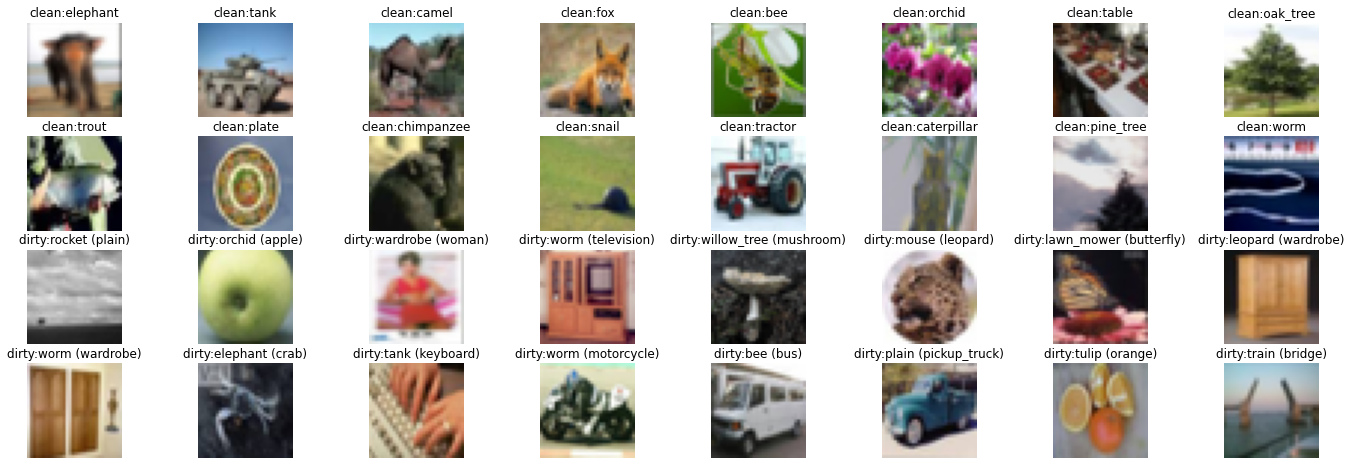

In [564]:
dataset_name = "cifar100"
noise_mode = "sym"
p = 0.4

if dataset_name == "cifar10":
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    train_dataset_viz = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=False, transform=test_transform)

elif dataset_name == "cifar100":
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

    train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    train_dataset_viz = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=False, transform=test_transform)
else:
    raise Exceptiion

kwargs = make_inherent_label_noise(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=123)
print(f"paths to files are: {kwargs}")

# make noisy label files
train_dataset, indices_noisy, noise_rules = add_inherent_label_noise(datapath, dataset_name, noise_mode, train_dataset, **kwargs)

# for viz
targets_clean = train_dataset_viz.targets
train_dataset_viz.targets = train_dataset.targets
train_dataset_viz.data = train_dataset.data

print(f"dataset_name:{dataset_name}, noise_mode:{noise_mode}, noise_ratio:{indices_noisy.sum() / len(train_dataset.targets)}")
print("noise_rules")
print(noise_rules)
print(indices_noisy)

params = {"noise_mode": noise_mode, "indices_noisy": indices_noisy}
if noise_mode in ["sym", "asym"]:
    params["targets_clean"] = targets_clean
elif noise_mode == "openset":
    pass
else:
    raise Exception

show_imgs(
    class_to_idx_list=list(train_dataset.class_to_idx.keys()), 
    train_dataset=train_dataset_viz,
    **params
)

In [554]:
indices_noisy

array([False,  True, False, ..., False, False,  True])

In [521]:
for img, label in enumerate(train_dataset.data[indices_noisy]):
    img, label = train_dataset[sample_idx]
    plt.imshow(img.permute(1,2,0))
    break

AttributeError: 'int' object has no attribute 'permute'

In [450]:
print(np.argwhere(indices_noisy).flatten())
print(np.argwhere(indices_noisy == False).flatten())

[    1     6     9 ... 49982 49987 49991]
[    0     2     3 ... 49997 49998 49999]


### Asym

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
data/cifar10/label_noisy/asym0.4_custom.csv generated

data/cifar10/label_noisy/asym0.4_custom_noise_rules.csv generated

{'labels_csv_path': 'data/cifar10/label_noisy/asym0.4_custom.csv', 'noise_rules_csv_path': 'data/cifar10/label_noisy/asym0.4_custom_noise_rules.csv'}
dataset_name:cifar10, noise_mode:asym, noise_ratio:0.16136
noise_rules
     src            dsts    p
0  truck  ['automobile']  0.4
1   bird    ['airplane']  0.4
2    cat         ['dog']  0.4
3    dog         ['cat']  0.4
[False  True False ... False False False]


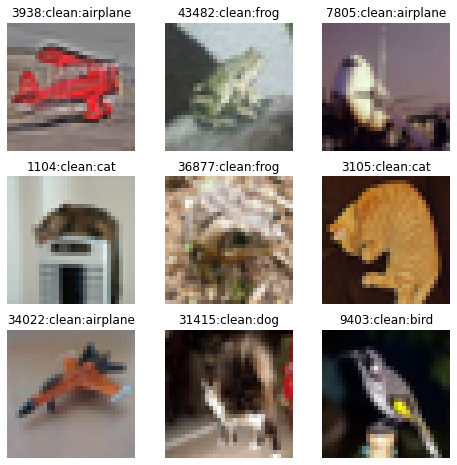

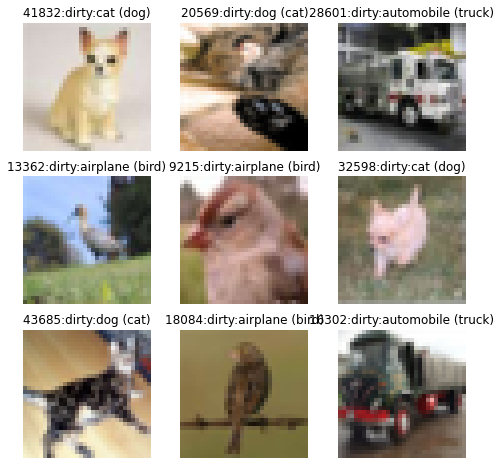

In [418]:
dataset_name = "cifar10"

if dataset_name == "cifar10":
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    train_dataset_viz = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=False, transform=test_transform)

p = 0.4
noise_mode = "asym"

kwargs = make_inherent_label_noise(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=123)
print(kwargs)
targets_clean = train_dataset.targets
train_dataset, indices_noisy, noise_rules = add_inherent_label_noise(datapath, dataset_name, noise_mode, train_dataset, **kwargs)
train_dataset_viz.targets = train_dataset.targets

print(f"dataset_name:{dataset_name}, noise_mode:{noise_mode}, noise_ratio:{indices_noisy.sum() / len(train_dataset.targets)}")
print("noise_rules")
print(noise_rules)
print(indices_noisy)

show_imgs(class_to_idx_list=list(train_dataset.class_to_idx.keys()), train_dataset=train_dataset_viz)
show_imgs(class_to_idx_list=list(train_dataset.class_to_idx.keys()), train_dataset=train_dataset_viz, 
          targets_clean=targets_clean, indices_noisy=indices_noisy)

### Openset

In [119]:
train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
make_openset_noise(dataset_name, train_dataset, p=0.4, seed=123)

Files already downloaded and verified
Files already downloaded and verified


In [120]:
train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
train_dataset.data = np.load("data/cifar10/label_noisy/openset0.4_custom.npy")

Files already downloaded and verified


In [121]:
train_dataset.data.shape

(50000, 32, 32, 3)

### Dependent

Use provided files

## CIFAR100

### Sym

In [161]:
dataset_name = "cifar100"
train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
noise_rules = make_sym_noise_rules(dataset_name, train_dataset)
print(noise_rules[:2])

df = pd.DataFrame(data=noise_rules)
print(df)

targets = torch.tensor(train_dataset.targets)
noisy_targets = targets.detach().clone()

for noise_rule in noise_rules:
    indices_per_rule, dirty_indicator_indices_per_rule, noisy_targets_per_rule = \
        make_sym_asym_noise(train_dataset, noise_rule["src"], noise_rule["dsts"], noise_rule["p"], seed=None)
    noisy_targets[indices_per_rule] = noisy_targets_per_rule[indices_per_rule]

print(torch.where(targets != noisy_targets)[0])
print(torch.where(targets != noisy_targets)[0].size(dim=0) / targets.size(dim=0))

df = pd.DataFrame(data={"label": targets.numpy(), "label_noisy": noisy_targets.numpy()})
print(df)
path_to_csv = "data/cifar100/label_noisy/sym0.4_custom.csv"
df.to_csv(path_to_csv, index=False)

Files already downloaded and verified
[{'src': 'apple', 'dsts': ['aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',

### Asym

In [160]:
dataset_name = "cifar100"
train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
noise_rules = make_asym_noise_rules(dataset_name, train_dataset)

df = pd.DataFrame(data=noise_rules)
print(df)
raise

targets = torch.tensor(train_dataset.targets)
noisy_targets = targets.detach().clone()

for noise_rule in noise_rules:
    indices_per_rule, dirty_indicator_indices_per_rule, noisy_targets_per_rule = \
        make_sym_asym_noise(train_dataset, noise_rule["src"], noise_rule["dsts"], noise_rule["p"], seed=None)
    noisy_targets[indices_per_rule] = noisy_targets_per_rule[indices_per_rule]

print(torch.where(targets != noisy_targets)[0])
print(torch.where(targets != noisy_targets)[0].size(dim=0))
print(torch.where(targets != noisy_targets)[0].size(dim=0) / targets.size(dim=0))

df = pd.DataFrame(data={"label": targets.numpy(), "label_noisy": noisy_targets.numpy()})
print(df)
path_to_csv = "data/cifar100/label_noisy/asym0.4_custom.csv"
df.to_csv(path_to_csv, index=False)

Files already downloaded and verified
              src             dsts    p
0            worm          [apple]  0.4
1           apple  [aquarium_fish]  0.4
2   aquarium_fish           [baby]  0.4
3            baby           [bear]  0.4
4            bear         [beaver]  0.4
..            ...              ...  ...
95       wardrobe          [whale]  0.4
96          whale    [willow_tree]  0.4
97    willow_tree           [wolf]  0.4
98           wolf          [woman]  0.4
99          woman           [worm]  0.4

[100 rows x 3 columns]


RuntimeError: No active exception to reraise

### Openset

No such combination

### Dependent

Use provided files

### Questions

- openset: cifar10 and cifar100 have overlapping classes, still in openset noise it is disregarded. what if we accidentally swap a dog in cifar10 for a dog in cifar100?
- openset: swapping transformed images in cifar10 to un-transformed in cifar100?
- normalization parameters?